# Asset Pricing with linearmodels

By Simon Van Norden & Nicolas Harvie
***

The [linearmodels](https://bashtage.github.io/linearmodels/) module has nice features for [Linear Factor Models for Asset Pricing](https://bashtage.github.io/linearmodels/asset-pricing/index.html) that are closely related to what we saw in the slides. We'll briefly show some of the features and how to use them.

## Models

The basic asset pricing model in ``linearmodels`` has the form

\begin{equation}
    r_{it} = \lambda_0 + \beta_i' \cdot \lambda_t + e_{it}
\end{equation}

where 
- $\lambda_t$ is our $K \times 1$ vector of factors
- $\beta_i$ is our $K \times 1$ vector of factor loadings for asset $i$
- $r_{it}$ is our rate of return on asset $i$
- $\lambda_0$ is the risk-free rate 

and we estimate the model using data on $P$ assets over $T$ periods. 

## Inference

Inference is closely related to the F-tests that we mentioned in the slides. However, 
- All standard errors allow for errors correlated across assets.
- Tests are only valid in large samples, so our test statistics will have $\chi^2$ distributions instead of $F$.
- ``cov_type=robust`` produces heteroscedasticity-robust standard errors. 
- ``cov_type=kernel`` produces heteroscedasticity-and-autocorrelation-robust (HAC) standard errors. 

## Estimation

The simplest case is the ``TradedFactorModel``, which corresponds to the factor models (like Fama and French) that we saw in the slides. 
- Estimation is by SUR (Seemingly Unrelated Regressions), which corresponds to a fixed-effects panel data model where errors may be clustered across assets but not time.
- This gives valid estimates **when we have factors measured in rates of return** (called _Traded Factors_.)

``LinearFactorModel`` may be used whether factors are traded or not (for example, when some factors are macroeconomic surprises.) 
- It first estimates _factor loadings_ using time series regressions on the factors, then uses these to estimate risk premia for the factors. 

``LinearFactorModelGMM`` is more sophisticated version of ``LinearFactorModel``, solving simultaneously for both the factor loading and the risk premium on each factor. 

## Examples

Let's look at some simple examples. (See [here](https://bashtage.github.io/linearmodels/doc/asset-pricing/examples/examples.html) for more.)

First, we can load some data from Ken French's data library. 
- includes 4 factor returns, the excess market, the size factor, the value factor and the momentum factor.

In [11]:
from linearmodels.datasets import french
data = french.load()
print(french.DESCR)
# Transform the returns to excess returns by substracting the risk-free rate.
data.iloc[:,6:] = data.iloc[:,6:].values - data[['RF']].values


Data from Ken French's data library
http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

dates    Year and Month of Return
MktRF    Market Factor
SMB      Size Factor
HML      Value Factor
Mom      Momentum Factor
RF       Risk-free rate
NoDur    Industry: Non-durables
Durbl    Industry: Durables
Manuf    Industry: Manufacturing
Enrgy    Industry: Energy
Chems    Industry: Chemicals
BusEq    Industry: Business Equipment
Telcm    Industry: Telecoms
Utils    Industry: Utilities
Shops    Industry: Retail
Hlth     Industry: Health care
Money    Industry: Finance
Other    Industry: Other
S1V1     Small firms, low value
S1V3     Small firms, medium value
S1V5     Small firms, high value
S3V1     Size 3, value 1
S3V3     Size 3, value 3
S3V5     Size 3, value 5
S5V1     Large firms, Low value
S5V3     Large firms, medium value
S5V5     Large Firms, High value
S1M1     Small firms, losers
S1M3     Small firms, neutral
S1M5     Small firms, winners
S3M1     Size 3, momentu

### CAPM

We'll estimate the CAPM model and test $\alpha_i = 0$ for all $i$ using some size and value sorted portfolios.
- Since the only factor is the market factor (which is traded), we can use ``TradedFactorModel``
- The $J$ statistic tests $H_0 : \alpha_i = 0 \; \forall \, i$

In [12]:
from linearmodels.asset_pricing import TradedFactorModel
# define our portfolio of assets
portfolios = data[['S1V1','S1V3','S1V5','S3V1','S3V3','S3V5','S5V1','S5V3','S5V5']]
# define our factors
factors = data[['MktRF']]
# define the model
mod = TradedFactorModel(portfolios, factors)
# fit the model
res = mod.fit()
# see what we got:
print(res)

                      TradedFactorModel Estimation Summary                      
No. Test Portfolios:                  9   R-squared:                      0.6910
No. Factors:                          1   J-statistic:                    70.034
No. Observations:                   819   P-value                         0.0000
Date:                  Wed, Jul 26 2023   Distribution:                  chi2(9)
Time:                          11:24:33                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MktRF          0.0065     0.0015     4.3553     0.0000      0.0035      0.0094

Covariance estimator:
Heteroskedast

The $J$-statistic strongly rejects the null hypothesis of correct specification.
- The risk premium on the market is strongly significant, so the market factor is priced in the market. 
- Note that the $R^2$ is 69%.

### Fama-French

What if we add the SMB, HML and Mom factors?

In [13]:
factors = data[['MktRF', 'SMB', 'HML', 'Mom']]
mod = TradedFactorModel(portfolios, factors)
res = mod.fit()
print(res)

                      TradedFactorModel Estimation Summary                      
No. Test Portfolios:                  9   R-squared:                      0.8982
No. Factors:                          4   J-statistic:                    45.907
No. Observations:                   819   P-value                         0.0000
Date:                  Wed, Jul 26 2023   Distribution:                  chi2(9)
Time:                          11:24:33                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MktRF          0.0065     0.0015     4.3553     0.0000      0.0035      0.0094
SMB            0.0016     0.0010    

$J$-statistic still strongly rejects $H_0$.
- All factors except SMB are strongly significant.
- $R^2$ improves to 90%.

We can see the estimated factor loadings using ``.betas``

         MktRF       SMB       HML       Mom
S1V1  1.100652  1.397569 -0.210653 -0.083748
S1V3  0.923878  1.088152  0.301926 -0.034765
S1V5  0.958739  1.084297  0.687914 -0.022665
S3V1  1.086251  0.752940 -0.429578 -0.047178
S3V3  0.971153  0.434311  0.364511 -0.049400
S3V5  1.068300  0.579893  0.814632 -0.035379
S5V1  0.987418 -0.239590 -0.357193 -0.000742
S5V3  0.935764 -0.248164  0.295728  0.006839
S5V5  1.103239 -0.085108  0.812956 -0.080834


<AxesSubplot: >

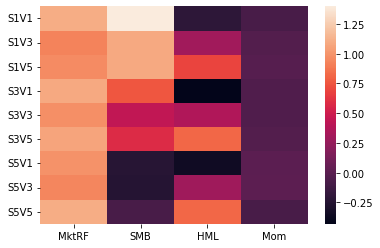

In [14]:
print(res.betas)

import seaborn as sns
%matplotlib inline
sns.heatmap(res.betas)

We can use either of the two other estimation methods to estimate the model if we want. 

How much difference does it make?

In [15]:
from linearmodels.asset_pricing import LinearFactorModel

mod2 = LinearFactorModel(portfolios, factors)
res2 = mod2.fit()
print(res2)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                  9   R-squared:                      0.8982
No. Factors:                          4   J-statistic:                    16.463
No. Observations:                   819   P-value                         0.0056
Date:                  Wed, Jul 26 2023   Distribution:                  chi2(5)
Time:                          11:24:33                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MktRF          0.0079     0.0017     4.6833     0.0000      0.0046      0.0112
SMB            0.0013     0.0016    

The $J$-statistic still rejects, but at a higher p-value <br>(The test is not as powerful due to the extra estimation error.)
- SMB and Mom not as significant as before (again, less power.)
- Identical $R^2$.


What about GMM?
- Note that GMM estimation is solved iteratively.

In [16]:
from linearmodels.asset_pricing import LinearFactorModelGMM

mod3 = LinearFactorModelGMM(portfolios, factors)
res3 = mod3.fit()
print(res3)

Iteration: 0, Objective: 22.08367067567724
Iteration: 10, Objective: 9.662322633083143
Iteration: 20, Objective: 7.145680524596338
Iteration: 30, Objective: 6.863204071462165
Iteration: 40, Objective: 4.636248193272177
Iteration: 50, Objective: 2.432023607228515
         Current function value: 2.431318
         Iterations: 60
         Function evaluations: 4871
         Gradient evaluations: 108
Iteration: 0, Objective: 2.458944056649321
Iteration: 10, Objective: 2.4507910789508136
Iteration: 20, Objective: 2.445481892641406
Iteration: 30, Objective: 2.4452447034561144
Iteration: 40, Objective: 2.441695789583556
         Current function value: 2.437830
         Iterations: 48
         Function evaluations: 4512
         Gradient evaluations: 100
                    LinearFactorModelGMM Estimation Summary                     
No. Test Portfolios:                  9   R-squared:                      0.8981
No. Factors:                          4   J-statistic:                    2.4378

Now we no longer reject the model!
- $R^2$ _almost_ unchanged.
- All factors significantly priced?